## COMP2006: Graded Lab 4

In this lab, you will gain some experience in dealing with missing data and further practice converting non-numeric features in a dataset to numeric.

**Target**: to predict `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1 | veh1_missing.csv |
| 2 | veh2_missing.csv |
| 3 | veh3_missing.csv |
| 4 | veh4_missing.csv |
| 5 | veh5_missing.csv |
| 6 | veh6_missing.csv |
| 7 | veh7_missing.csv |
| 8 | veh8_missing.csv |
| 10 | veh10_missing.csv |

**Important Notes:**
- Use [Chapter 7](https://mlbook.explained.ai/bulldozer-intro.html) of the textbook as a **guide**:
     - you only need to use **random forest** models;
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit Anaconda, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective

> **Don't make assumptions!**


### Part 0

### Group Number 7
 - Manuel Bishop Noriega - ID 4362207
 - Robert E. Matney III - ID: 4364229

     

## **Part 1 - Create and evaluate an initial model**

In this part you should: 
 - use Section 7.3 of the textbook as a guide, except:
     - use all of the data; and
     - use 150 decision trees in your random forest models
 - read in the data
 - isolate all numeric features from original data set
 - fill in any missing values with 0
 - create and evaluate a baseline model 

#### Code (10 marks)

### **Importing libraries and setting up some useful functions**

In [1]:
import pandas as pd
# from rfpimp import *
from rfpimp_MC import *
from pandas.api.types import is_string_dtype, is_object_dtype
from pandas.api.types import is_categorical_dtype
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
import warnings # to avoid some warnings about plots
warnings.filterwarnings('ignore')

# ------------------------------------------- HELPER FUNCTIONS ----------------------------------------------

# ------------------------------------------- EVALUATE FUNCTION ---------------------------------------------
# to prevent repeating code we created an evaluation function called evaluate # it will take features and
# target as parameters and use them to create and fit a random forest regressor model and calculate it's
# oob performance. It returns a tuple with rf model and its oob average from 10 runs
def evaluate(X,y):
    oob_scores = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    oob=sum(oob_scores) / len(oob_scores)
    print(f'Mean OOB score: {oob}')
    print(f'{rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height')
    return rf, oob

# ----------------------------------------- FEATURES IMPORTANCES --------------------------------------------
# showimp() show features importances, it accepts up to 4 params
# rf: a randomforest regressor
# X,y are the features and target
# features, I added this to perform different tests while converting non-numeric features
# plots the features' importances graphic
def showimp(rf,X,y):
    I=importances(rf,X,y)
    plot_importances(I,color='blue')

# --- we took this function from book, useful to quickly identify most obvious missing values in dataset ---
def sniff(df):
    # with pd.option_context("display.max_colwidth",20):
        info=pd.DataFrame()
        #info['sample']=df.iloc[120] #no needed here
        info['data type']=df.dtypes
        info['percent missing']=df.isnull().sum()*100/len(df)
        return info.sort_values('data type')

# ---------------- we'll use this many times during this lab, so we're saving keystrokes -------------------
def get_unique_values_in_columns(df):
     print('PRINTING UNIQUE VALUES PER COLUMN\n')
     for col in df.columns:
          print(f'{col} : {df[col].unique()}')

#--------------------------------------- FUNCTIONS TO NORMALIZE --------------------------------------------
#                           missing values in numeric and non-numeric features
# NON-NUMERIC FEATURES: receives dataframe to normalize and a string with all values to replace
# and returns it 
def normalize_nonum(df,missing_values_str):   
    for col in df.columns:
        df[col]=df[col].str.lower()
        df[col]=df[col].fillna(np.nan)
        df[col]=df[col].replace(missing_values_str, np.nan)
    return df

# NUMERIC FEATURES: receives the dataframe to normalize and returns it
def normalize_num(df):
    for col in df.columns:
        df[col]=df[col].replace(0,np.nan)
    return df

# --------------------------------------- FUNCTIONS TO LABEL ENCODE -----------------------------------------
#                non-numeric features as ordinal, taken from book, this will fix missing values
# this converts dtype for each column to ordinal category.
def df_string_to_cat(df):
    for col in df.columns:
        if is_object_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()
# this loop transform nominal values in to integers according to categories previously assigned
def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

# ------------------------- FUNCTION TO HANDLE MISSING VALUES ---------------------------
#                in numeric features based on the one showed in the book.
def fix_missing_num(df):
    r=df.isna().any()  # get the columns with missing values
    msvrows=r[r==True].index
    for e in msvrows:       #now loop through those columns and replace missing values with median
        df[e+'_na']=pd.isnull(df[e])
        df[e].fillna(df[e].median(), inplace=True)

### **First, let's take a look of our data set**

In [2]:
#-------------------------- reading the data ----------------------
df = pd.read_csv("veh7_missing.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 12 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Eng Displ                                                  831 non-null    float64
 1   # Cyl                                                      1196 non-null   int64  
 2   Comb Unadj FE - Conventional Fuel                          1196 non-null   object 
 3   # Gears                                                    1196 non-null   int64  
 4   Max Ethanol % - Gasoline                                   1164 non-null   float64
 5   Intake Valves Per Cyl                                      1196 non-null   int64  
 6   Exhaust Valves Per Cyl                                     1196 non-null   int64  
 7   Stop/Start System (Engine Management System)  Description  1196 non-null   object 
 8   Lockup T

,Eng Displ,# Cyl,Comb Unadj FE - Conventional Fuel,# Gears,Max Ethanol % - Gasoline,Intake Valves Per Cyl,Exhaust Valves Per Cyl,Stop/Start System (Engine Management System) Description,Lockup Torque Converter,Calc Approach Desc,Cyl Deact?,Trans Creeper Gear
0,4.4,8,20.538,7,10.0,2,2,Yes,,not filled in,^^,N
1,2.0,4,34.5365,6,15.0,2,2,No,NaN,not filled in,^^,N
2,3.4,6,31.5932,7,10.0,2,2,none,N,not filled in,N,N
3,4.4,8,22.0246,6,10.0,2,2,none,N,Derived 5-cycle label,N,N
4,4.3,6,25.772,6,85.0,1,1,No,NaN,not filled in,^^,N


In [3]:
sniff(df) # this function taken from book tells us the percentage of missing values in features

,data type,percent missing
# Cyl,int64,0.000000
# Gears,int64,0.000000
Intake Valves Per Cyl,int64,0.000000
Exhaust Valves Per Cyl,int64,0.000000
Eng Displ,float64,30.518395
Max Ethanol % - Gasoline,float64,2.675585
Comb Unadj FE - Conventional Fuel,object,0.000000
Stop/Start System (Engine Management System) Description,object,0.000000
Lockup Torque Converter,object,18.979933
Calc Approach Desc,object,0.000000


***
It seems that we have some missing values in our dataset. We know that because info() shows how many non-nulls value are in every column (if the number is lower than total entries then we have some nulls), head() lets us take a look of data we have in the dataset too. Sniff function is another tool to overview data set by returning a percentage of missing values per feature. But because we want to quickly build our baseline model, let's just use numeric features by now and fill in missing values with 0 and keep going with building and evaluating baseline model.

**NOTE:**
 After doing the above, while trying to fit our model we got an error `ValueError: could not convert string to float: 'Mod'` then we realized that target feature was shown as `object dtype` in df.info() even when values seem to be all float, after a closer look we found some missing values hidden behind 'Mod' string in our target feature. Then, `given they were missing values too, we just proceeded as instructed and replaced them with value 0.`
***

In [4]:
# ---------------------------- pulling out numeric features and filling in missing values with 0 -----------------------------------
df_num=df.select_dtypes(include=['number']) 
num_features=df_num.columns.tolist()
df_num=df_num.fillna(0)
df_num.isna().any() # to confirm there're no more missing values

Eng Displ                   False
# Cyl                       False
# Gears                     False
Max Ethanol % - Gasoline    False
Intake Valves Per Cyl       False
Exhaust Valves Per Cyl      False
dtype: bool

In [5]:
# ----------------------------- pulling out target feature and filling in missing values with 0 too -------------------------------------
y=pd.to_numeric(df['Comb Unadj FE - Conventional Fuel'],errors='coerce',downcast='float') # if it's not a number then replace it with NaN
target_feature=['Comb Unadj FE - Conventional Fuel']
y=y.fillna(0) # can't have missing values in y, then fill in them with 0

### **Creating and evaluating BASELINE model**

Mean OOB score: 0.6961122167713147
37,506 tree nodes and 15.0 median tree height


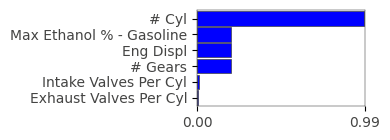

In [6]:
rf_baseline,oob1=evaluate(df_num,y)
showimp(rf_baseline,df_num,y)

## **Part 2 - Normalize missing values**

In this part you should: 
 - use Section 7.4 of the textbook as a guide
 - convert **all** representations of missing data to a **single** representation
 
#### Code (15 marks)

***
**ONCE Baseline model was created and tested** we'll clean data as much as possible and try to get improve results.

Because apparently there are no outliers or any other inconsistencies in numeric features and missing values were converted to 0, we'll check now non numeric features to identify all missing values and then normalize all of them to NaN.
***

In [7]:
df_nonum=df.drop(num_features+target_feature,axis=1)
get_unique_values_in_columns(df_nonum)

PRINTING UNIQUE VALUES PER COLUMN

Stop/Start System (Engine Management System)  Description : ['Yes' 'No' 'none']
Lockup Torque Converter : ['   ' nan 'N' 'Y']
Calc Approach Desc : ['not filled in' 'Derived 5-cycle label' 'Vehicle Specific 5-cycle label'
 'Derived Vehicle Specific 5-cycle Calculation Approach for city label but Modified 5-cycle Calculation Approach for Highway label']
Cyl Deact? : ['^^' 'N' 'Y']
Trans Creeper Gear : ['N' 'Y']


***
We found missing values in non-numeric features in the form of 'none', '', nan, 'not filled in', '^^'. we'll convert them all to NaN. Now We'll normalize numeric features too.
***

In [8]:
# --------------- normalizing missing values to NaN in non numeric features -----------------
missing_values_str=['none','   ','not filled in','^^']
df_nonum=normalize_nonum(df_nonum,missing_values_str)

# ------------------ let's normalize missing values in numeric features too -----------------
df_num=normalize_num(df_num)

#### Question (5 marks)

Note here all the different ways missing data was represented in the data.   

***
**Enter your answer here:**
in numeric features we found nan and in target feature we found 'Mod'
in non-numeric features, we found 'none', '', nan, 'not filled in', '^^'
***

## **Part 3 - Categorical features**
In this part you should: 
 - use Section 7.5.1 as a guide
 - only use ordinal encoding 
 - convert **all** non-numeric features to numeric 
 - handle any missing values
 
#### Code (25 marks)

In [9]:
# by using the functions df_string_to_cat and df_cat_to_catcode we are performing label encoding,
# first function changes columns dtype to ordered category, then 2nd function transforms them into
# integer values. similar to what cd.OrdinalEnconder will do through mapping. this way we've handled
# missing values by converting them in category with value 0.
df_string_to_cat(df_nonum)
df_cat_to_catcode(df_nonum)

## **Part 4 - Numeric features**

In this part you should: 
 - use Section 7.5.2 as a guide
 - handle any missing values
 
#### Code (30 marks)

In [10]:
# let's replace all missing values in numeric columns with that column median value. 
fix_missing_num(df_num)
# now put features alltogether to feed our final model
df_fixed=pd.concat([df_num,df_nonum],axis=1)

***
 We weren't sure about how to proceed with target feature **(y)**, so instead of making assumptions we decided to test our final model with 3 different versions of it:
 1. the same we used for baseline model, with missing values filled in with 0's
 2. one with missing values filled in with median value
 3. one in which we simply dropped the rows having those missing values. We decided to try this because missing values in target feature were only around 1.1% so we thought it might have positive impact in model's performance.
***

In [11]:
#------------------------- preparing our 3 versions for target feature array ----------------------------
# first case is (y)
#case 2, (ym). we'll use the same dataframe for features.
ym=y.replace(0,y.median())

#case 3, let's drop those rows and call new training set Xdr, ydr.
dfdr=pd.concat([df_num,df_nonum,y], axis=1)
dfdr.drop(dfdr[(dfdr[target_feature[0]]==0)].index,axis=0, inplace=True)
Xdr,ydr=dfdr.drop(target_feature[0],axis=1),dfdr[target_feature[0]]

## **Part 5 - Create and evaluate a final model**

In this part you should:
 - create and evaluate a model using all the features after processing them in Parts 2, 3, and 4 above 

#### Code (10 marks)

Mean OOB score: 0.7136009645304899
107,824 tree nodes and 19.0 median tree height


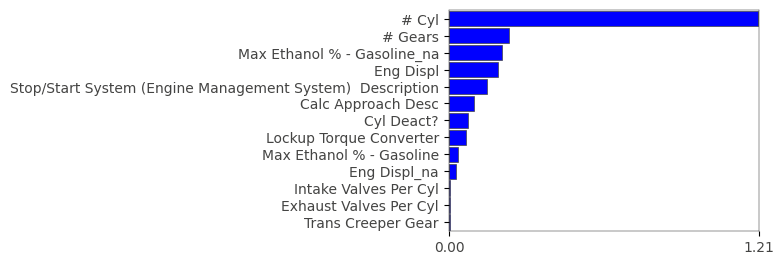

In [12]:
# 1st test final model using fixed X, same y used in baseline
rf_mv1,oob2=evaluate(df_fixed,y)
showimp(rf_mv1,df_fixed,y)

Mean OOB score: 0.801631270662283
108,358 tree nodes and 19.0 median tree height


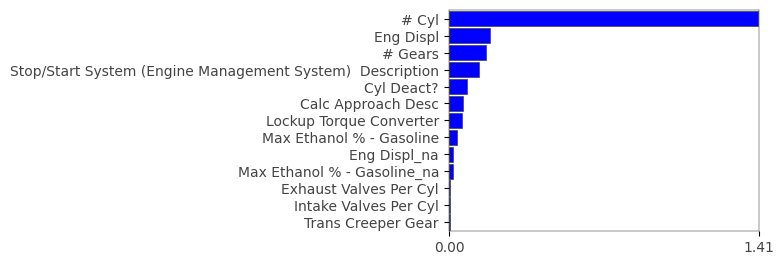

In [13]:
# 2nd test, using fixed X and y (missing values replaced with median)
rf_mv2,oob3=evaluate(df_fixed,ym)
showimp(rf_mv2,df_fixed,ym)

Mean OOB score: 0.8163911998461465
107,058 tree nodes and 19.0 median tree height


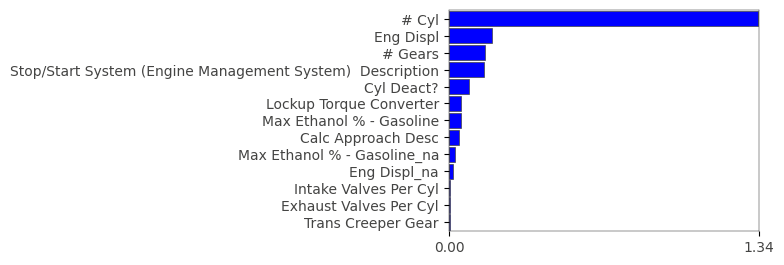

In [14]:
# 3rd test, dropping rows with missing values in target feature.
rf_mv3,oob4=evaluate(Xdr,ydr)
showimp(rf_mv3,Xdr,ydr)

#### Questions (5 marks)

Provide answers to the following:
 1. calculate the percent difference between the results of Part 1 and Part 5 (make sure you are using the correct formula for percent difference) 
 2. based on the percent difference, state whether or not the results of Part 5 are an improvement over the results of Part 1

**Enter your answers here:**
### AT THE END, it seems the best choice was dropping those few rows...
It's interesting to observe how features importances can fluctuate too with different adjustments we do.

Finally, let's compare our final model performance vs baseline model.

In [15]:
# calculating percentage difference between results of part1 and part3
# a positve values means improvement, negative values means the new model performs worse than the baseline
resultDiff=((oob4*100)/oob1)-100 
# printing results and statement after assessing results
print(f'The FINAL MODEL after features encoding and missing values treatment showed:\n {"IMPROVEMENT" if resultDiff>0 else "WORSE PERFORMANCE"} by {resultDiff:.2f}% compared to BASELINE MODEL\n')

The FINAL MODEL after features encoding and missing values treatment showed:
 IMPROVEMENT by 17.28% compared to BASELINE MODEL

